In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer 
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, chi2, mutual_info_classif
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import ExtraTreesClassifier
import xgboost
from sklearn.model_selection import train_test_split
numerical_transformer = RobustScaler()

In [2]:
df = pd.read_csv('2/Base.csv')

In [3]:
len(df)

1000000

In [4]:
df.columns

Index(['fraud_bool', 'income', 'name_email_similarity',
       'prev_address_months_count', 'current_address_months_count',
       'customer_age', 'days_since_request', 'intended_balcon_amount',
       'payment_type', 'zip_count_4w', 'velocity_6h', 'velocity_24h',
       'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'employment_status',
       'credit_risk_score', 'email_is_free', 'housing_status',
       'phone_home_valid', 'phone_mobile_valid', 'bank_months_count',
       'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source',
       'session_length_in_minutes', 'device_os', 'keep_alive_session',
       'device_distinct_emails_8w', 'device_fraud_count', 'month'],
      dtype='object')

In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fraud_bool,1000000.0,0.011029,0.104438,0.000000e+00,0.000000,0.000000,0.000000,1.000000
income,1000000.0,0.562696,0.290343,1.000000e-01,0.300000,0.600000,0.800000,0.900000
name_email_similarity,1000000.0,0.493694,0.289125,1.434550e-06,0.225216,0.492153,0.755567,0.999999
prev_address_months_count,1000000.0,16.718568,44.046230,-1.000000e+00,-1.000000,-1.000000,12.000000,383.000000
current_address_months_count,1000000.0,86.587867,88.406599,-1.000000e+00,19.000000,52.000000,130.000000,428.000000
customer_age,1000000.0,33.689080,12.025799,1.000000e+01,20.000000,30.000000,40.000000,90.000000
days_since_request,1000000.0,1.025705,5.381835,4.036860e-09,0.007193,0.015176,0.026331,78.456904
intended_balcon_amount,1000000.0,8.661499,20.236155,-1.553055e+01,-1.181488,-0.830507,4.984176,112.956928
zip_count_4w,1000000.0,1572.692049,1005.374565,1.000000e+00,894.000000,1263.000000,1944.000000,6700.000000
velocity_6h,1000000.0,5665.296605,3009.380665,-1.706031e+02,3436.365848,5319.769349,7680.717827,16715.565404


In [6]:
(df['fraud_bool'].value_counts() / len(df))*100

fraud_bool
0    98.8971
1     1.1029
Name: count, dtype: float64

In [7]:
df.isnull().sum()

fraud_bool                          0
income                              0
name_email_similarity               0
prev_address_months_count           0
current_address_months_count        0
customer_age                        0
days_since_request                  0
intended_balcon_amount              0
payment_type                        0
zip_count_4w                        0
velocity_6h                         0
velocity_24h                        0
velocity_4w                         0
bank_branch_count_8w                0
date_of_birth_distinct_emails_4w    0
employment_status                   0
credit_risk_score                   0
email_is_free                       0
housing_status                      0
phone_home_valid                    0
phone_mobile_valid                  0
bank_months_count                   0
has_other_cards                     0
proposed_credit_limit               0
foreign_request                     0
source                              0
session_leng

In [8]:
df.dtypes

fraud_bool                            int64
income                              float64
name_email_similarity               float64
prev_address_months_count             int64
current_address_months_count          int64
customer_age                          int64
days_since_request                  float64
intended_balcon_amount              float64
payment_type                         object
zip_count_4w                          int64
velocity_6h                         float64
velocity_24h                        float64
velocity_4w                         float64
bank_branch_count_8w                  int64
date_of_birth_distinct_emails_4w      int64
employment_status                    object
credit_risk_score                     int64
email_is_free                         int64
housing_status                       object
phone_home_valid                      int64
phone_mobile_valid                    int64
bank_months_count                     int64
has_other_cards                 

In [9]:
numerical = [feature for feature in df.columns if df[feature].nunique() >= 10]

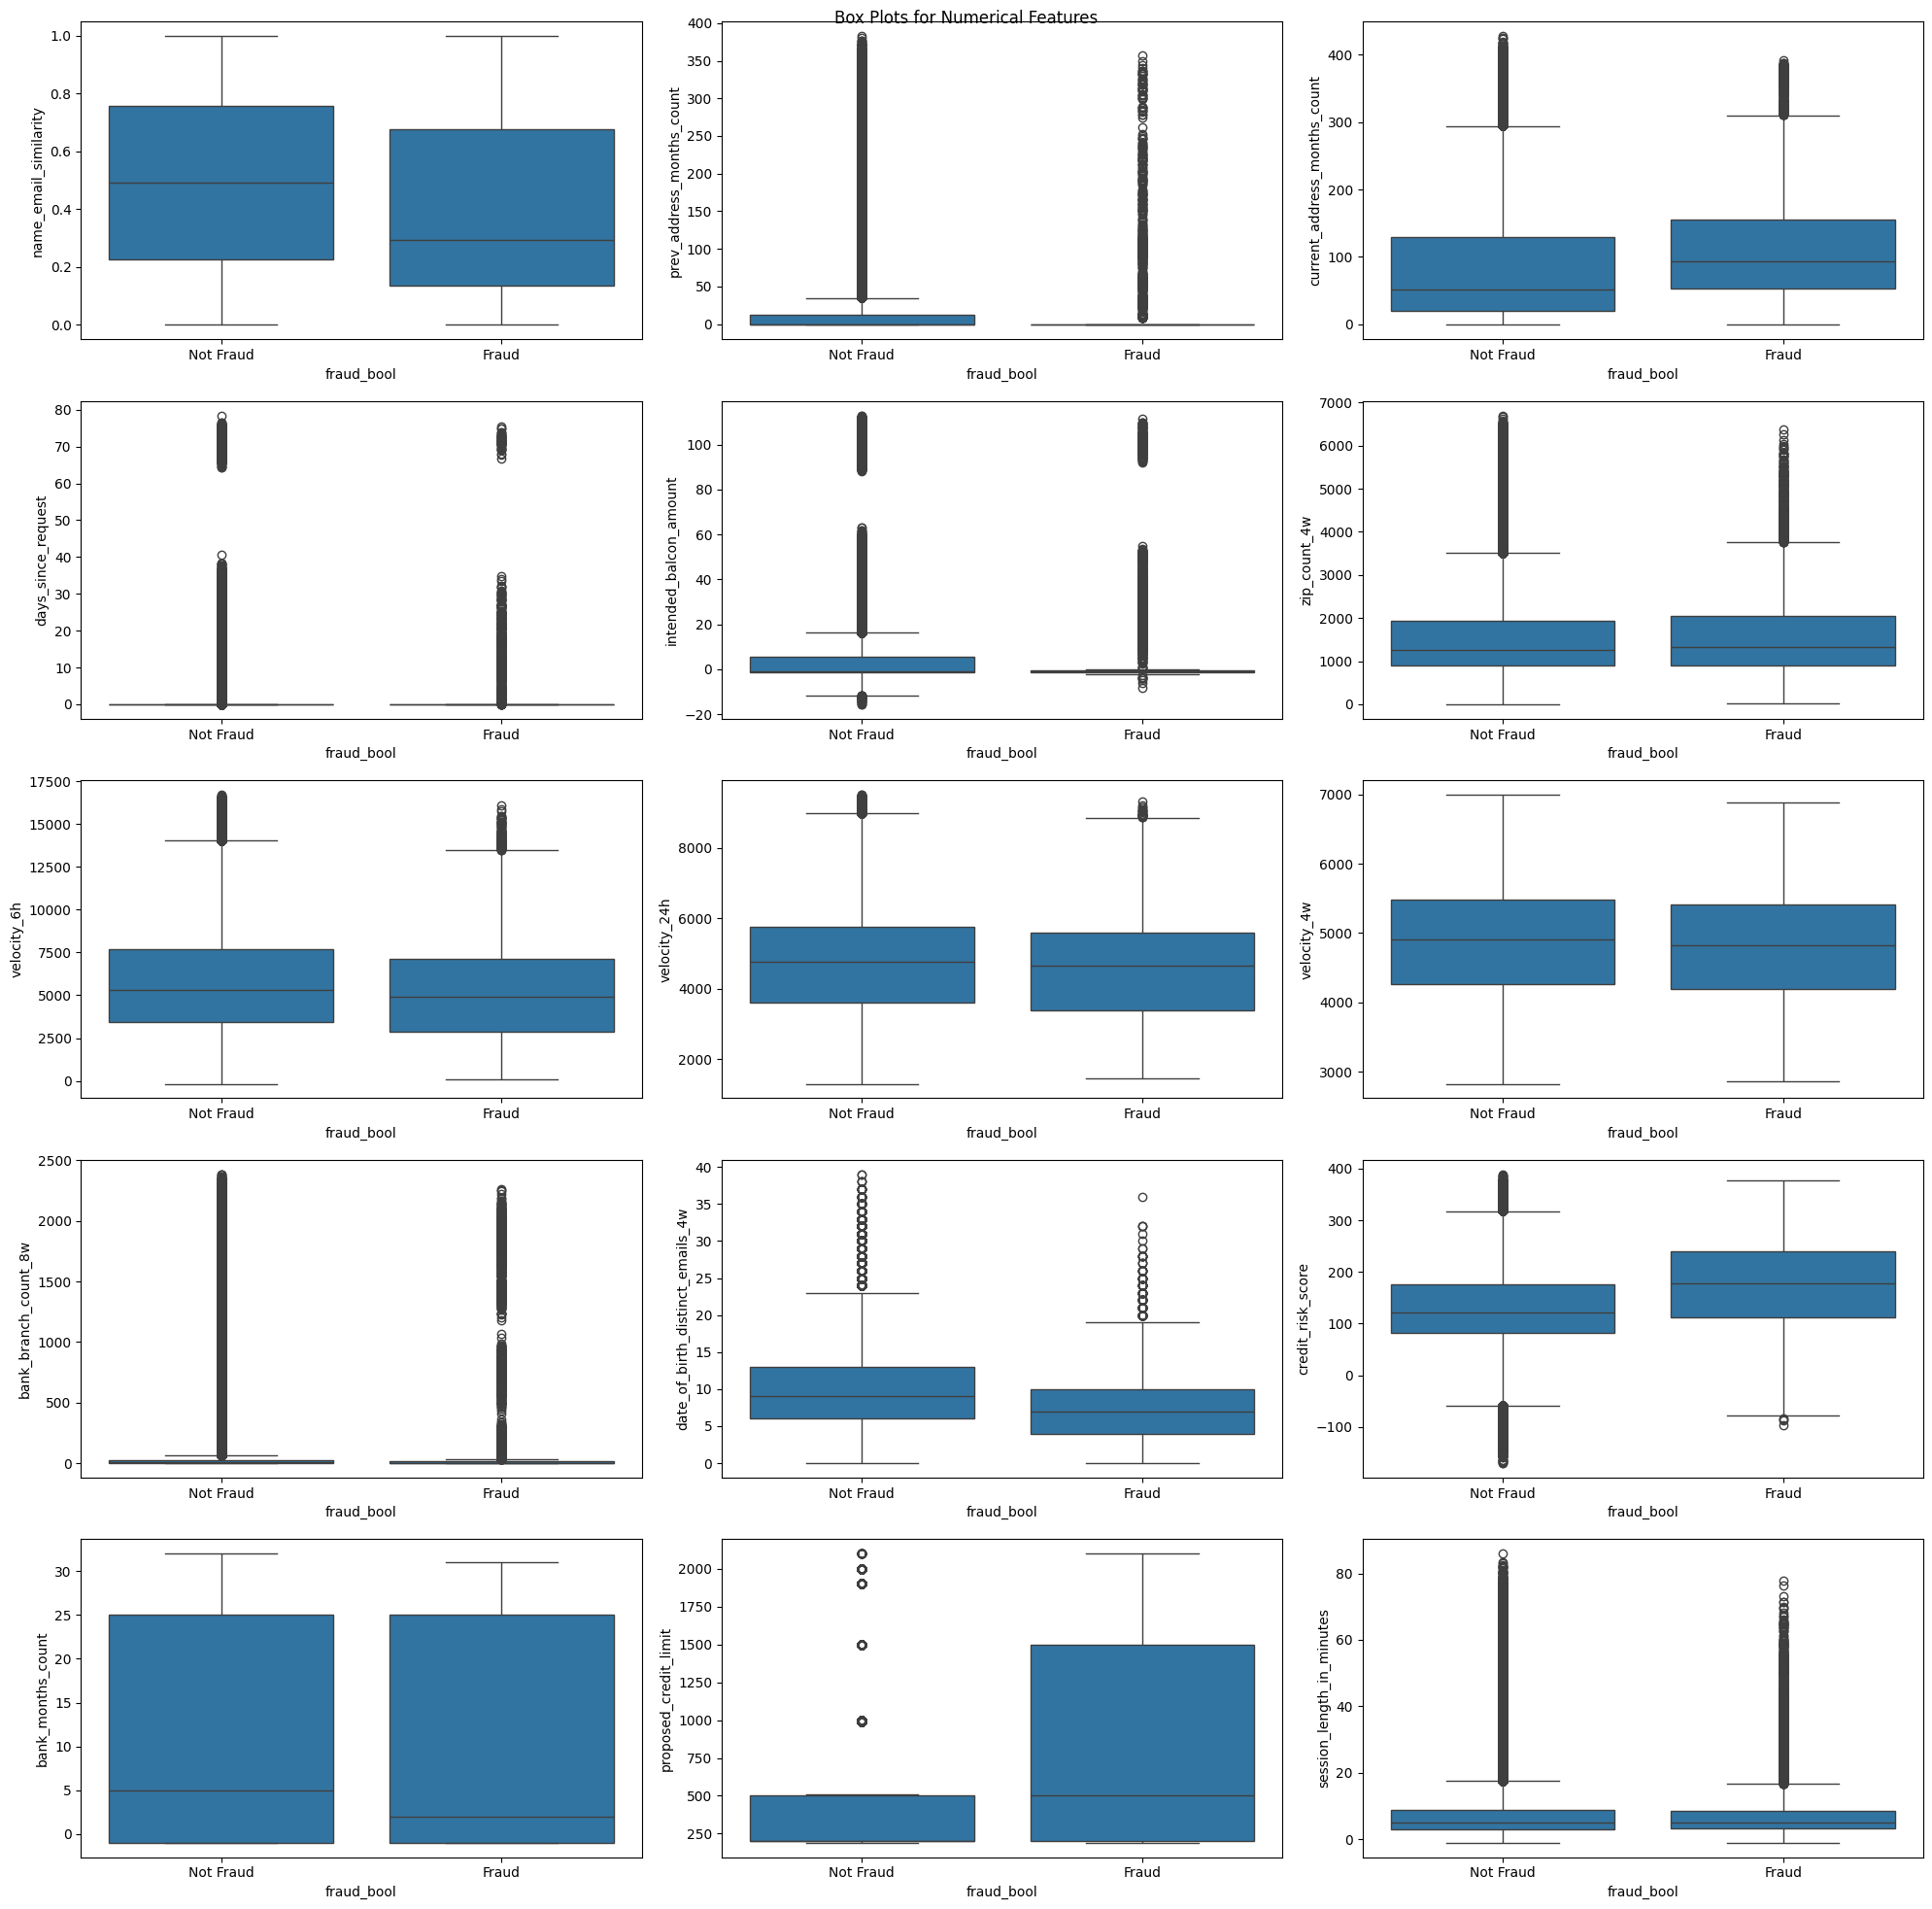

In [10]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 20))
fig.suptitle("Box Plots for Numerical Features")
for i, feature in enumerate(numerical):
    ax = axes[i//3][i%3]
    sns.boxplot(data=df, x='fraud_bool', y=feature, ax=ax)
    ax.set_xlabel('fraud_bool')
    ax.set_xticks([0, 1])
    ax.set_ylabel(feature)
    ax.set_xticklabels(['Not Fraud', 'Fraud'])
plt.tight_layout()
plt.show()

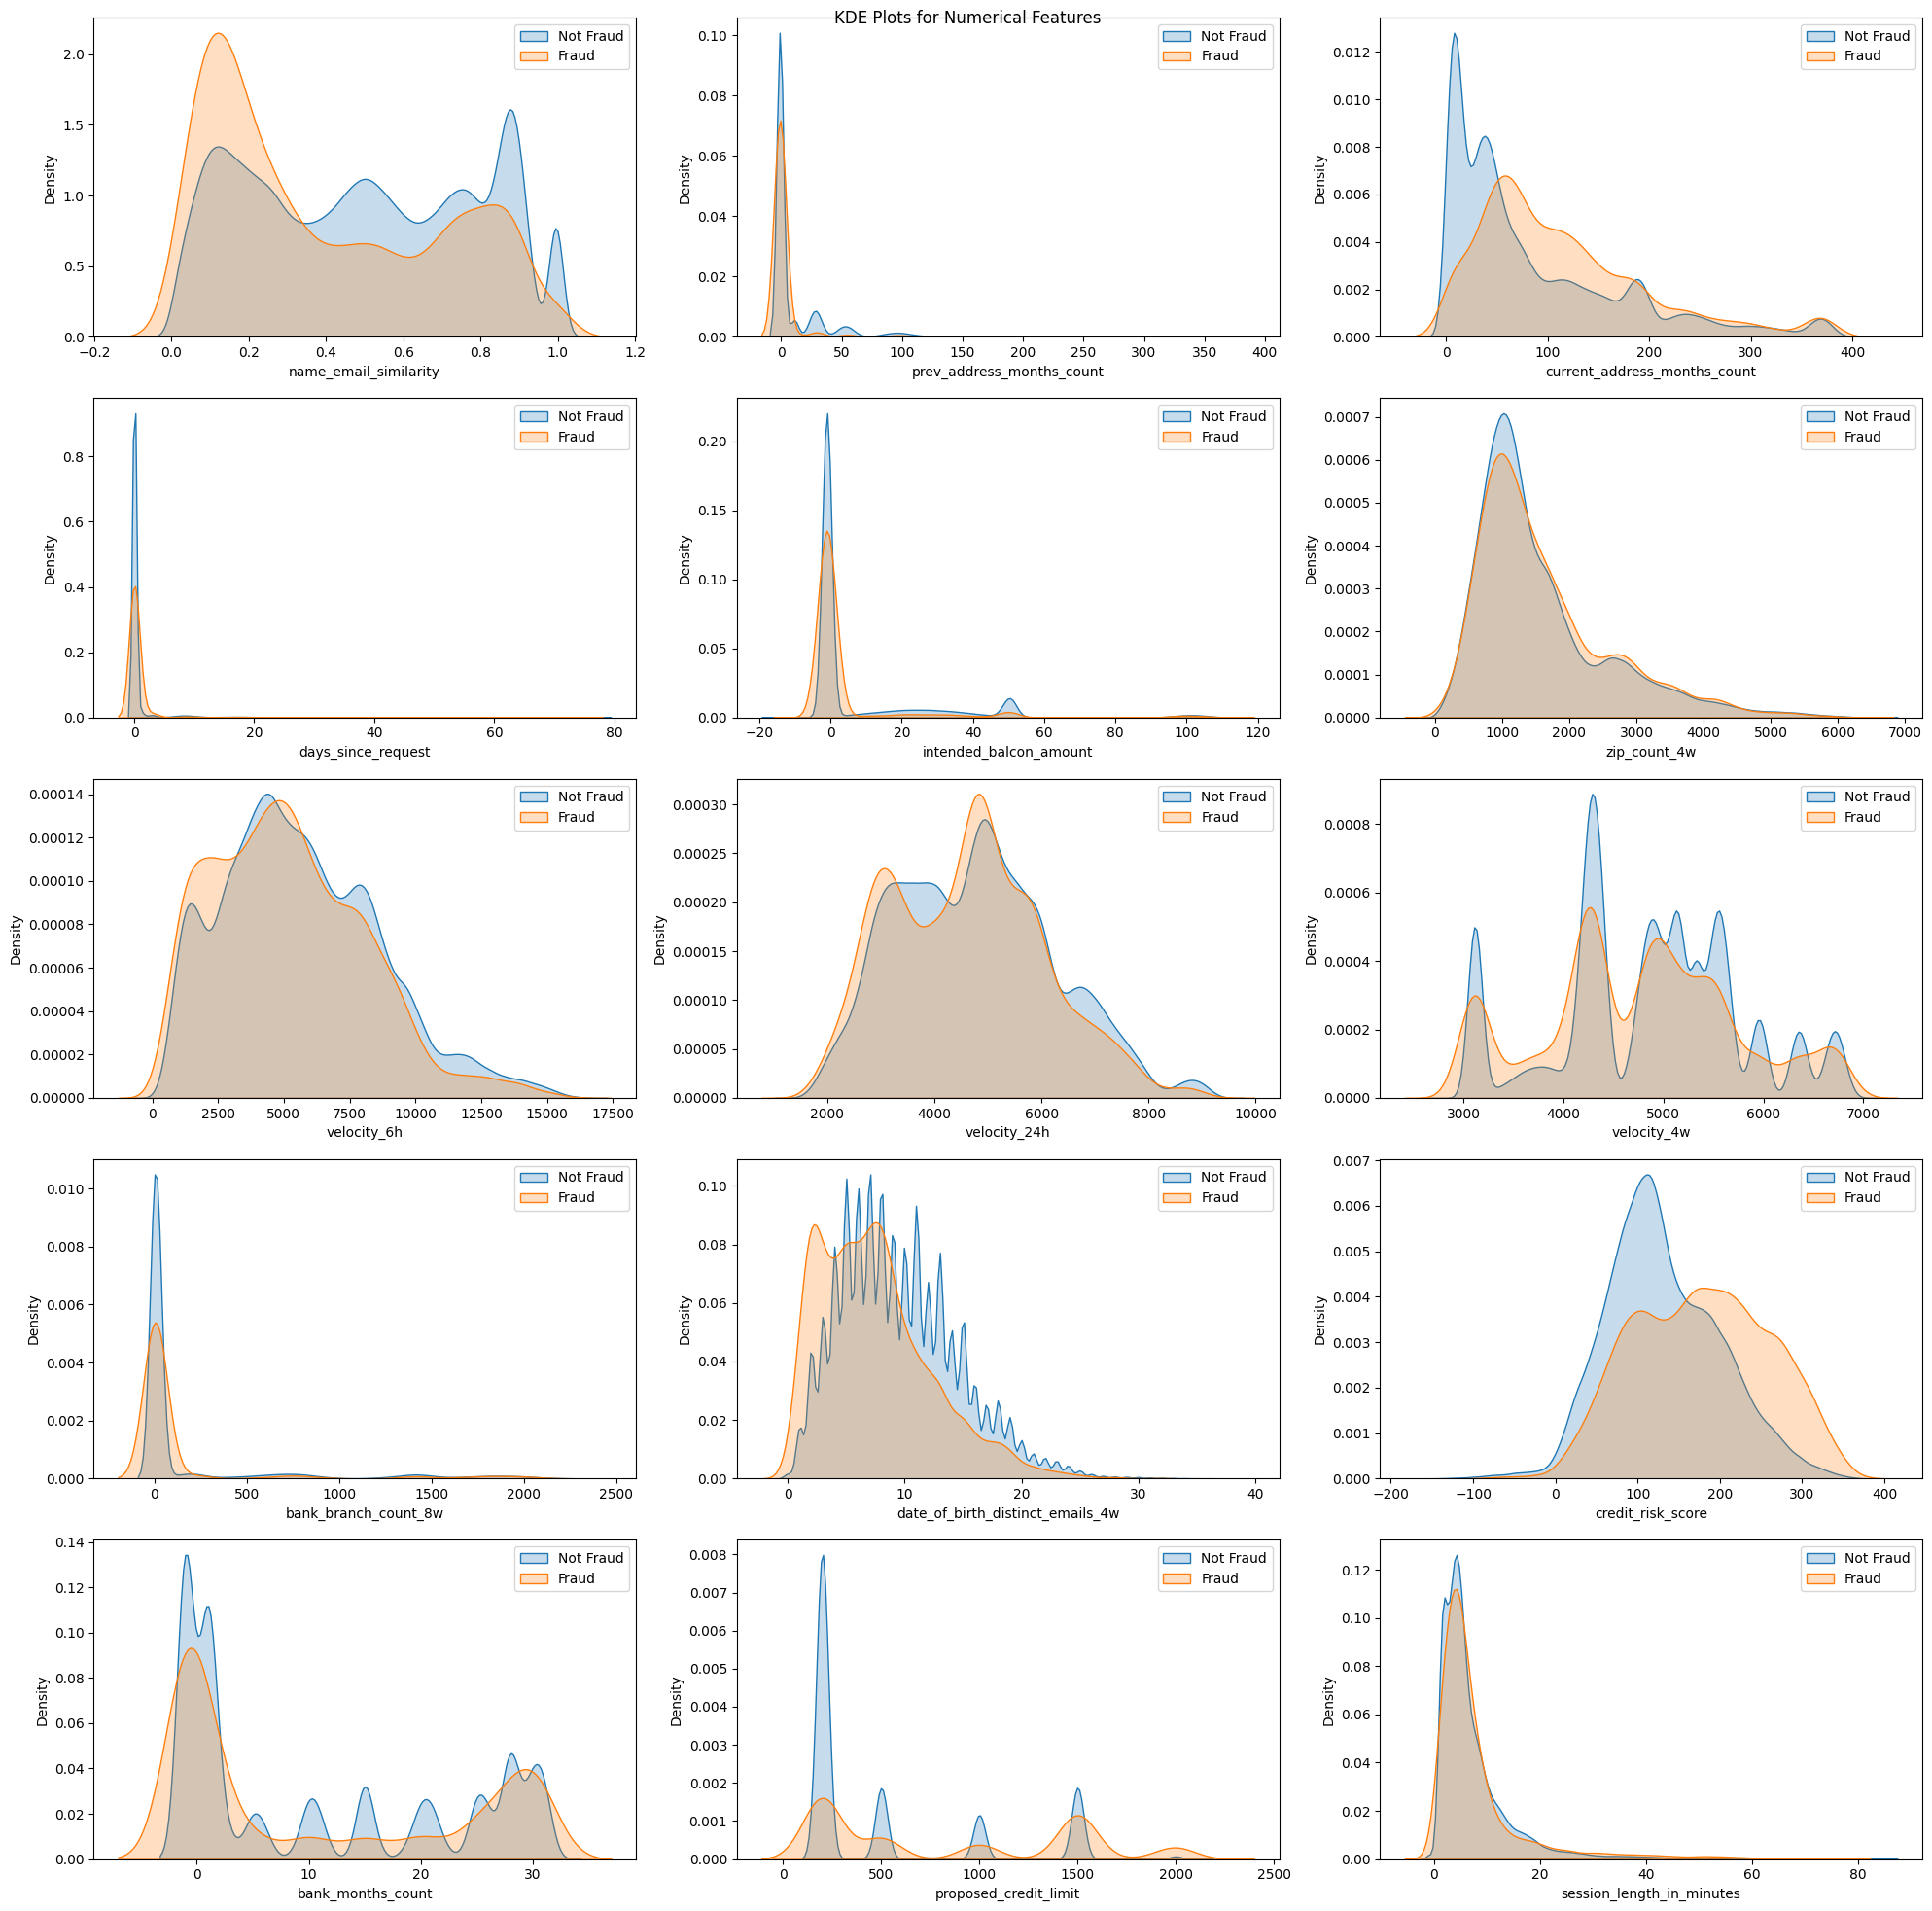

In [11]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 20))
fig.suptitle("KDE Plots for Numerical Features")
for i, feature in enumerate(numerical):
    ax = axes[i//3][i%3]
    sns.kdeplot(data=df[df['fraud_bool'] == 0][feature], fill=True, ax=ax, label='Not Fraud')
    sns.kdeplot(data=df[df['fraud_bool'] == 1][feature], fill=True, ax=ax, label='Fraud')
    ax.set_xlabel(feature)
    ax.legend()
plt.tight_layout()
plt.show()

In [12]:
categorical = [feature for feature in df.columns if df[feature].dtype == 'object']

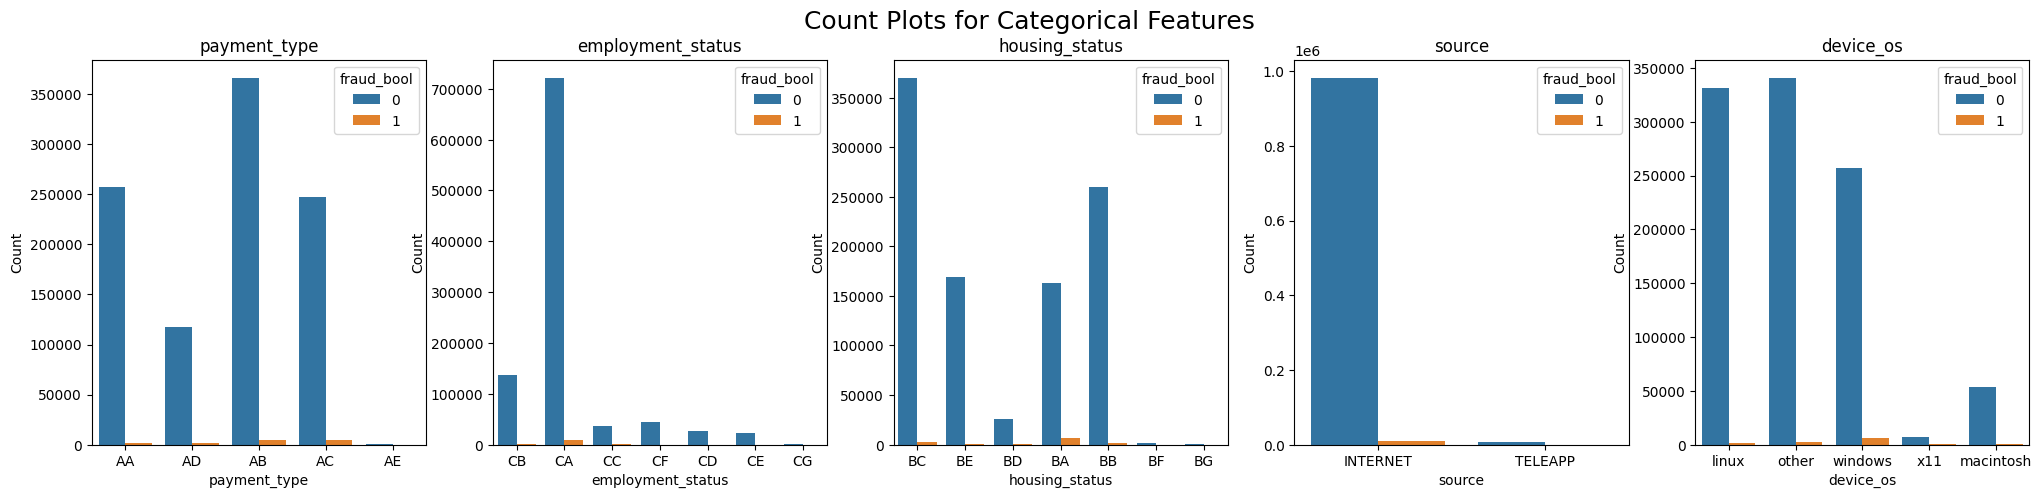

In [13]:
fig, axes = plt.subplots(nrows = 1, ncols=5, figsize=(25, 5))
fig.suptitle("Count Plots for Categorical Features", fontsize=18)
for i, feature in enumerate(categorical):
    sns.countplot(data=df, x=feature, hue="fraud_bool", ax=axes[i])
    axes[i].set_ylabel("Count")
    axes[i].set_title(f"{feature}")
plt.show()

In [14]:
new_df = df.copy()
new_df = pd.DataFrame(pd.get_dummies(new_df, prefix = categorical))
print(new_df.shape[1])

53


In [15]:
X = new_df.drop('fraud_bool', axis=1)
y = new_df['fraud_bool']

In [16]:
preprocessor = ColumnTransformer([('scaled', numerical_transformer, numerical)], remainder='passthrough')
X_scaled = preprocessor.fit_transform(X)

In [17]:
feature_names = preprocessor.get_feature_names_out()
feature_names = [feature.replace('remainder__', '') for feature in feature_names]
print(feature_names)

['scaled__name_email_similarity', 'scaled__prev_address_months_count', 'scaled__current_address_months_count', 'scaled__days_since_request', 'scaled__intended_balcon_amount', 'scaled__zip_count_4w', 'scaled__velocity_6h', 'scaled__velocity_24h', 'scaled__velocity_4w', 'scaled__bank_branch_count_8w', 'scaled__date_of_birth_distinct_emails_4w', 'scaled__credit_risk_score', 'scaled__bank_months_count', 'scaled__proposed_credit_limit', 'scaled__session_length_in_minutes', 'income', 'customer_age', 'email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'has_other_cards', 'foreign_request', 'keep_alive_session', 'device_distinct_emails_8w', 'device_fraud_count', 'month', 'payment_type_AA', 'payment_type_AB', 'payment_type_AC', 'payment_type_AD', 'payment_type_AE', 'employment_status_CA', 'employment_status_CB', 'employment_status_CC', 'employment_status_CD', 'employment_status_CE', 'employment_status_CF', 'employment_status_CG', 'housing_status_BA', 'housing_status_BB', 'housing_status_B

In [18]:
X_scaled = pd.DataFrame(X_scaled, columns=feature_names)

In [19]:
categorical_features = [feature for feature in X_scaled.columns if X_scaled[feature].nunique() >= 2 and X_scaled[feature].nunique() < 10]

print(categorical_features)

['income', 'customer_age', 'email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'has_other_cards', 'foreign_request', 'keep_alive_session', 'device_distinct_emails_8w', 'month', 'payment_type_AA', 'payment_type_AB', 'payment_type_AC', 'payment_type_AD', 'payment_type_AE', 'employment_status_CA', 'employment_status_CB', 'employment_status_CC', 'employment_status_CD', 'employment_status_CE', 'employment_status_CF', 'employment_status_CG', 'housing_status_BA', 'housing_status_BB', 'housing_status_BC', 'housing_status_BD', 'housing_status_BE', 'housing_status_BF', 'housing_status_BG', 'source_INTERNET', 'source_TELEAPP', 'device_os_linux', 'device_os_macintosh', 'device_os_other', 'device_os_windows', 'device_os_x11']


In [20]:
numeric_features = [feature for feature in X_scaled.columns if X_scaled[feature].nunique() >= 10]

print(numeric_features)

['scaled__name_email_similarity', 'scaled__prev_address_months_count', 'scaled__current_address_months_count', 'scaled__days_since_request', 'scaled__intended_balcon_amount', 'scaled__zip_count_4w', 'scaled__velocity_6h', 'scaled__velocity_24h', 'scaled__velocity_4w', 'scaled__bank_branch_count_8w', 'scaled__date_of_birth_distinct_emails_4w', 'scaled__credit_risk_score', 'scaled__bank_months_count', 'scaled__proposed_credit_limit', 'scaled__session_length_in_minutes']


In [21]:
selector = VarianceThreshold()
selector.fit(X_scaled)
constant_features = [feature for feature in X_scaled.columns 
                     if feature not in X_scaled.columns[selector.get_support()]]
print(constant_features)

['device_fraud_count']


In [22]:
df.drop('device_fraud_count', axis=1, inplace=True)

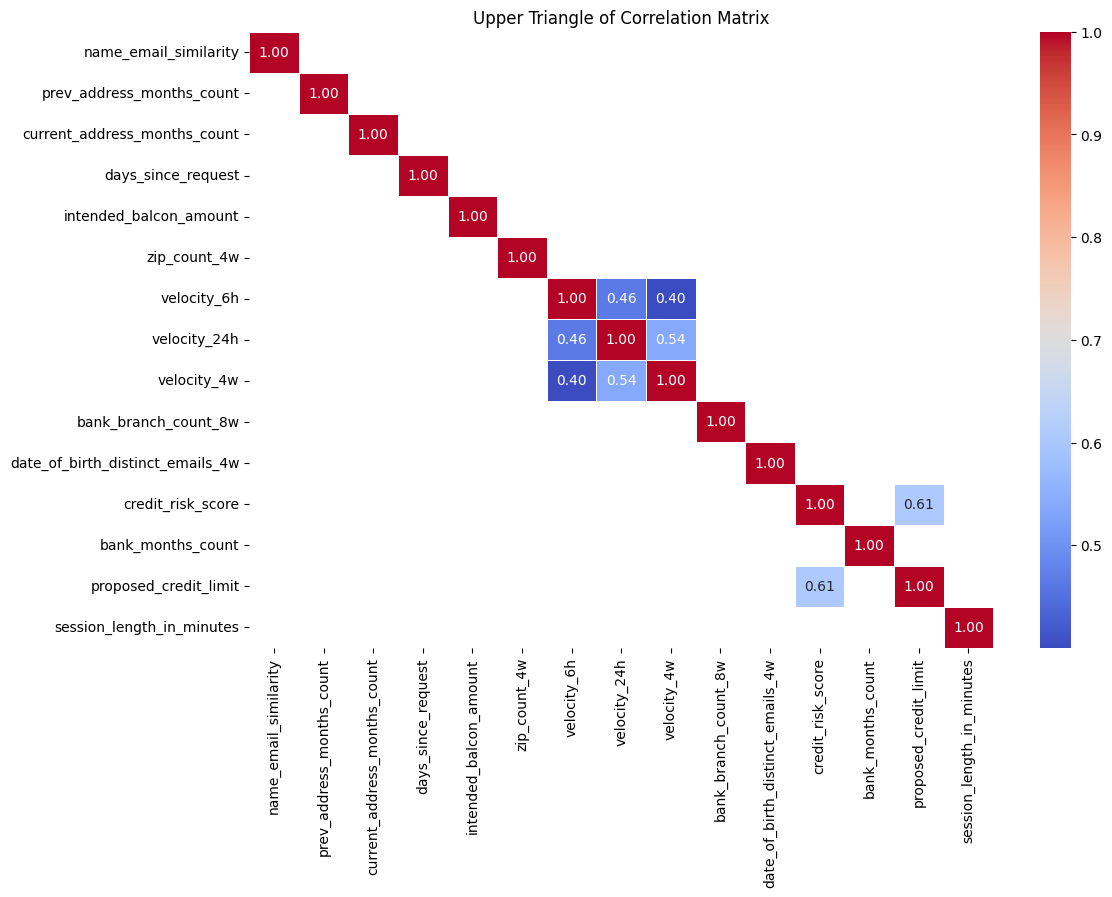

In [23]:
corr_matrix = df[numerical].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix[(corr_matrix >= 0.4) | (corr_matrix <= -0.4)], annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Upper Triangle of Correlation Matrix")
plt.show()

In [24]:
X_scaled.device_distinct_emails_8w.value_counts()

device_distinct_emails_8w
1     968067
2      25302
0       6272
-1       359
Name: count, dtype: int64

In [25]:
rows_to_drop = np.where(X_scaled['device_distinct_emails_8w'] < 0)[0]
rows_to_drop
X_train_cat = X_scaled[categorical_features].copy()
X_train_cat.drop(rows_to_drop, axis=0, inplace=True)
y_train_cat = y.copy()
y_train_cat.drop(rows_to_drop, axis=0, inplace=True)

In [26]:
chi2_results = chi2(X_train_cat, y_train_cat)

In [27]:
chi2_results_df = pd.DataFrame(data={'feature': X_train_cat.columns, 'chi2': chi2_results[0], 'p_value': chi2_results[1]})

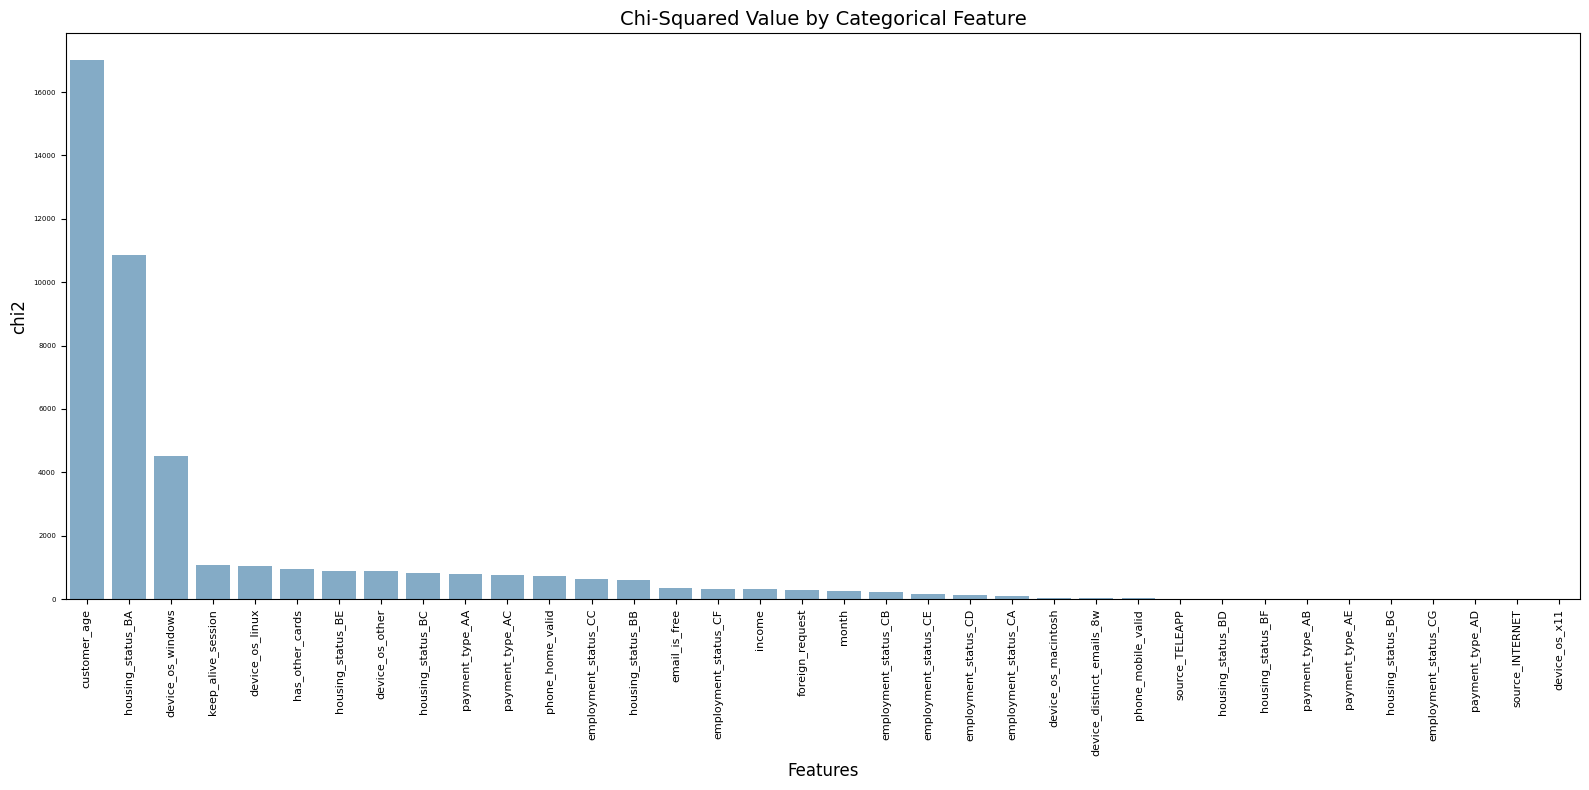

In [28]:
plt.figure(figsize=(16, 8))
sns.barplot(data=chi2_results_df.sort_values(by='chi2', ascending=False), x="feature", y="chi2",alpha=.6)
plt.xlabel("Features", fontsize=12)
plt.ylabel("chi2", fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=5)
plt.title("Chi-Squared Value by Categorical Feature", fontsize=14)
plt.tight_layout()
plt.show()

In [29]:
best_chi2_cols = SelectKBest(chi2, k=5)
best_chi2_cols.fit(X_train_cat, y_train_cat)
best_chi2_features = [X_train_cat.columns[best_chi2_cols.get_support()]]
print(best_chi2_features)

[Index(['customer_age', 'keep_alive_session', 'housing_status_BA',
       'device_os_linux', 'device_os_windows'],
      dtype='object')]


In [31]:
X_train_num = df[numerical].copy()
y_train_num = y.copy()

In [32]:
mutual_info_results = mutual_info_classif(X_train_num, y_train_num)

In [33]:
mutual_info_df = pd.DataFrame(data={'feature': X_train_num.columns, 'mutual_info_result': mutual_info_results})

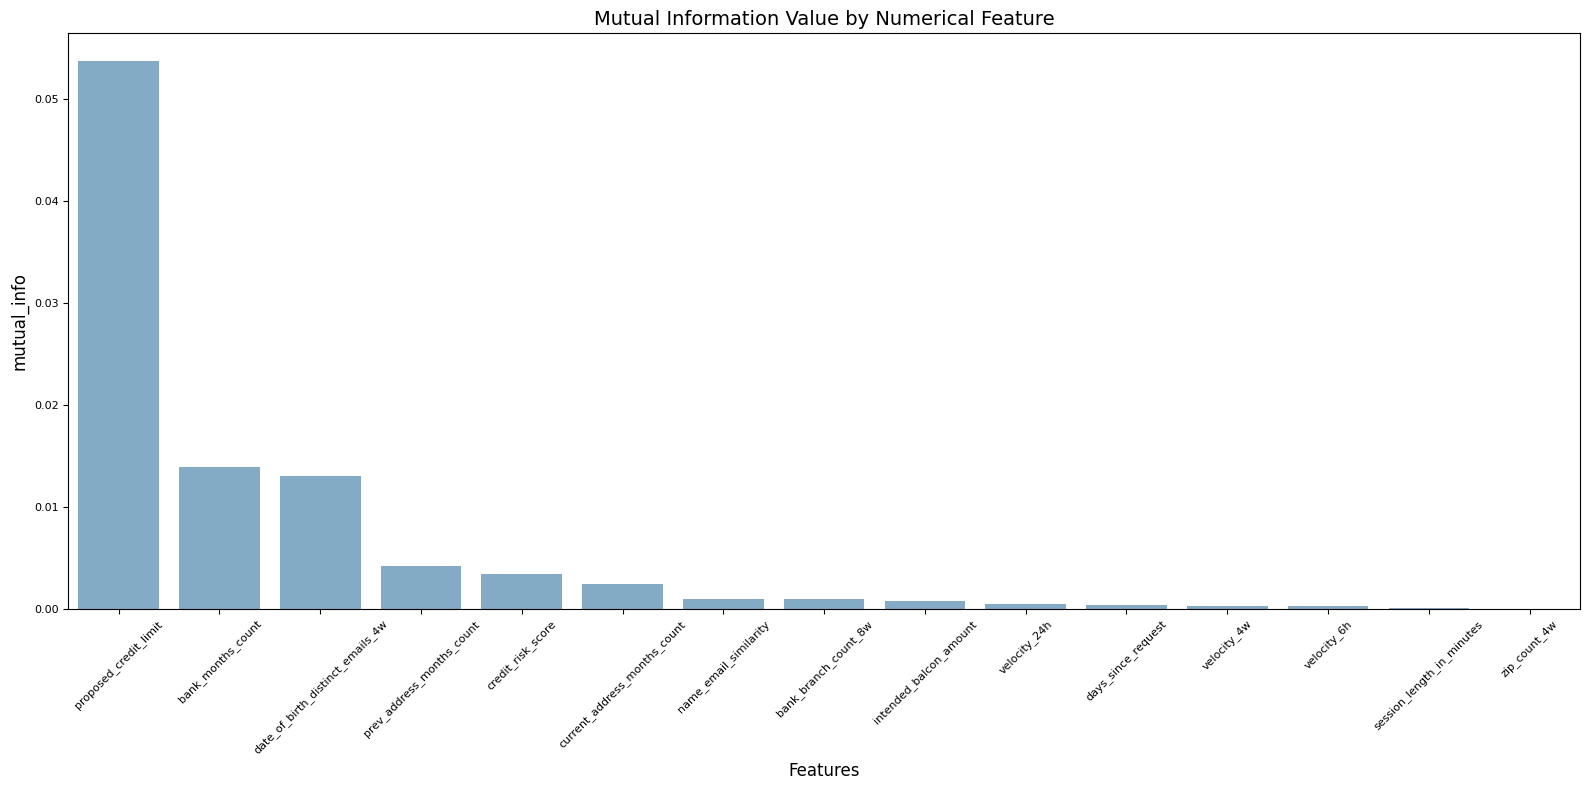

In [37]:
plt.figure(figsize=(16, 8))
sns.barplot(data=mutual_info_df.sort_values(by='mutual_info_result', ascending=False), x="feature", y="mutual_info_result", alpha=.6)
plt.xlabel("Features", fontsize=12)
plt.ylabel("mutual_info", fontsize=12)
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.title("Mutual Information Value by Numerical Feature", fontsize=14)
plt.tight_layout()
plt.show()

In [38]:
best_mutual_info_cols = SelectKBest(mutual_info_classif, k=5)
best_mutual_info_cols.fit(X_train_num, y_train_num)
best_mutual_info_features = [X_train_num.columns[best_mutual_info_cols.get_support()]]
print(best_mutual_info_features)

[Index(['prev_address_months_count', 'date_of_birth_distinct_emails_4w',
       'credit_risk_score', 'bank_months_count', 'proposed_credit_limit'],
      dtype='object')]


In [39]:
extra = ExtraTreesClassifier(n_estimators=50, random_state=0)
extra.fit(X_scaled, y)
feature_sel_extra = SelectFromModel(extra, prefit=True)
best_extra_features = [X_scaled.columns[(feature_sel_extra.get_support())]]
best_extra_features = list(best_extra_features[0])
print(best_extra_features)

['scaled__name_email_similarity', 'scaled__current_address_months_count', 'scaled__days_since_request', 'scaled__intended_balcon_amount', 'scaled__zip_count_4w', 'scaled__velocity_6h', 'scaled__velocity_24h', 'scaled__velocity_4w', 'scaled__bank_branch_count_8w', 'scaled__date_of_birth_distinct_emails_4w', 'scaled__credit_risk_score', 'scaled__bank_months_count', 'scaled__proposed_credit_limit', 'scaled__session_length_in_minutes', 'income', 'customer_age', 'month']


In [40]:
extra_importances = pd.DataFrame({'feature': X_scaled.columns, 'importance': extra.feature_importances_})

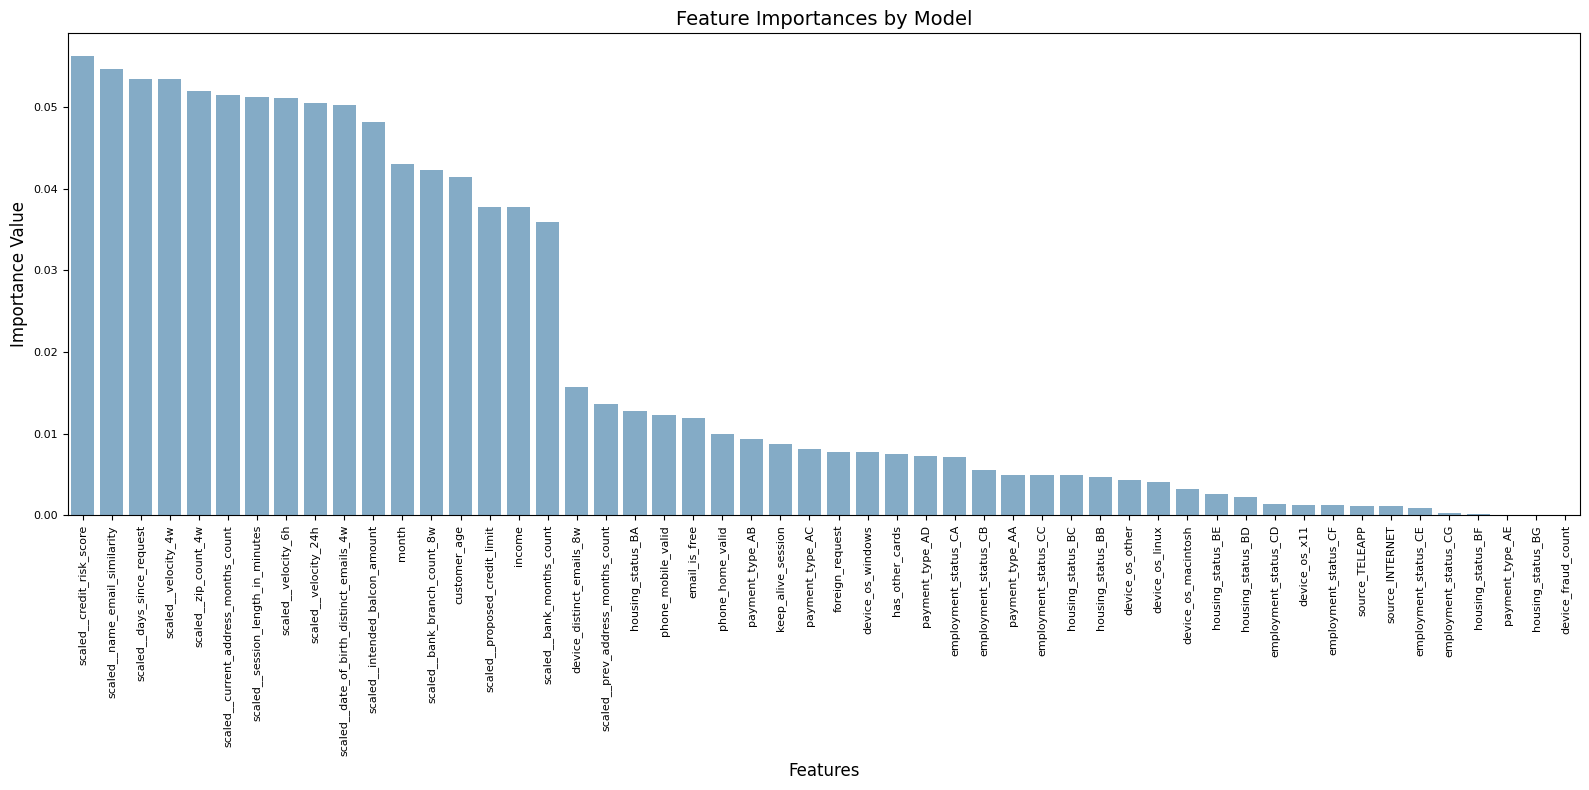

In [44]:
plt.figure(figsize=(16, 8))
sns.barplot(data=extra_importances.sort_values(by='importance', ascending=False), x="feature", y="importance",alpha=.6)
plt.xlabel("Features", fontsize=12)
plt.ylabel("Importance Value", fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)
plt.title("Feature Importances by Model", fontsize=14)
plt.tight_layout()
plt.show()